In [1]:
import aacgmv2, time
import pandas as pd
import numpy as np
from multiprocessing import Pool
import math, os, shutil
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from scipy.io import readsav
import pymap3d as pm
import glob
import datetime, statistics
from aetherpy.io import read_routines
from math import cos, radians, sin, sqrt
from scipy import spatial, signal

from spacepy.coordinates import Coords
from spacepy.time import Ticktock
import fnmatch


from mpl_toolkits.basemap import Basemap
import geopandas
import sys

from scipy.interpolate import LinearNDInterpolator, interp1d

%matplotlib inline

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Settings

In [3]:
dtime_storm_start = datetime.datetime(2011,5,21,13,40) 
plot_start_delta  = 4   #hours before storm onset to start making plots
plot_end_delta    = 10  # hours after storm onset to end plots. Set to -1 to run for the whole time


gitm_cols = ['Rho', '[O(!U3!NP)]', '[O!D2!N]', '[N!D2!N]', '[N(!U4!NS)]', '[NO]', '[He]', '[N(!U2!ND)]', '[N(!U2!NP)]', '[H]', '[CO!D2!N]', '[O(!U1!ND)]', 'Temperature', 'V!Dn!N(east)', 'V!Dn!N(north)', 'V!Dn!N(up)', 'V!Dn!N(up,O(!U3!NP))', 'V!Dn!N(up,O!D2!N)', 'V!Dn!N(up,N!D2!N)', 'V!Dn!N(up,N(!U4!NS))', 'V!Dn!N(up,NO)', 'V!Dn!N(up,He)', '[O_4SP_!U+!N]', '[NO!U+!N]', '[O!D2!U+!N]', '[N!D2!U+!N]', '[N!U+!N]', '[O(!U2!ND)!U+!N]', '[O(!U2!NP)!U+!N]', '[H!U+!N]', '[He!U+!N]', '[e-]', 'eTemperature'] #, 'iTemperature', 'V!Di!N(east)', 'V!Di!N(north)', 'V!Di!N(up)'] # which gitm columns do you want plotted?


gitm_path = "/home/axb170054/scratch/GITM-testing/test_folders/step_function_driving/SAMI3-stretch/gitm_data/"


gitm_alt_idxs = [7,15,30,40] #set this to -1 if you want all columns
gitm_keo_lons = [-90,2,90,-178]

global_lat_lim = None # will limit all plots latitude. Must be none or less than keo_lat_lim

keo_lat_lim = 65 # limits keos to +/- degrees of lat. 

num_pool_workers = 10 # number of workers to use in multithreading jobs. Set to 1 if you don't know what this means.

both_map_plots = True # make both_map_plots filtered and raw maps? if you only want one put it as a str ('raw'/'filt')


available gitm cols are:
    ['Longitude', 'Latitude', 'Altitude', 'Rho', '[O(!U3!NP)]', '[O!D2!N]', '[N!D2!N]', '[N(!U4!NS)]', '[NO]', '[He]', '[N(!U2!ND)]', '[N(!U2!NP)]', '[H]', '[CO!D2!N]', '[O(!U1!ND)]', 'Temperature', 'V!Dn!N(east)', 'V!Dn!N(north)', 'V!Dn!N(up)', 'V!Dn!N(up,O(!U3!NP))', 'V!Dn!N(up,O!D2!N)', 'V!Dn!N(up,N!D2!N)', 'V!Dn!N(up,N(!U4!NS))', 'V!Dn!N(up,NO)', 'V!Dn!N(up,He)', '[O_4SP_!U+!N]', '[NO!U+!N]', '[O!D2!U+!N]', '[N!D2!U+!N]', '[N!U+!N]', '[O(!U2!ND)!U+!N]', '[O(!U2!NP)!U+!N]', '[H!U+!N]', '[He!U+!N]', '[e-]', 'eTemperature', 'iTemperature', 'V!Di!N(east)', 'V!Di!N(north)', 'V!Di!N(up)']

In [4]:
gitm_keo_save_path = "/home/axb170054/scratch/made_plots/SimStormPaper/keos/"
gitm_map_save_path = "/home/axb170054/scratch/made_plots/SimStormPaper/maps/"

## Do GITM Plots First

In [5]:
gitm_files = np.sort(glob.glob(gitm_path+'3DALL*'))

gitm_dtimes = []
for i in gitm_files:
    yy, MM, dd, hr, mm, sec = i[-17:-15], i[-15:-13], i[-13:-11], i[-10:-8], i[-8:-6], i[-6:-4]
    gitm_dtimes.append(datetime.datetime(int('20' + yy), int(MM), int(dd), int(hr), int(mm), int(sec)))
    
storm_start_index = np.argmin(np.abs(np.array(gitm_dtimes)-dtime_storm_start))
plot_start_idx = np.argmin(np.abs(np.array(gitm_dtimes)-(dtime_storm_start - datetime.timedelta(hours = plot_start_delta))))
plot_end_idx = np.argmin(np.abs(np.array(gitm_dtimes)-(dtime_storm_start + datetime.timedelta(hours = plot_end_delta)))) if plot_end_delta != -1 else -1

### Read in all gitm files

In [99]:
def read_gitm_into_nparrays(flist):
    """reads a list of gitm filenames and returns a few numpy arrays.
    
    Parameters
    ----------
    flist: list
        List of gitm filenames to read in.
    
    Returns
    -------
    gitmtimes = list
        Datetimes corresponding to the times of the gitm files.
    gitmgrid = dict. 
        Holds the gitm grid for reference. lons/lats have been 
        changed to degrees from rads. Ghost cells removed.
        Keys are ['longitude', 'latitude', 'altitude']
        Index with gitmgrid[time][key][lon][lat][alt]
    gitmvars = list
        The gitm variables.
    gitmbins = numpy array. 
        All of the gitm data (except grid)
        index with gitmbins[time,varnumber,lat,lon,alt]
    
    """
    
    gitmtimes = []
    
    start = True
    for ifile, file_name in enumerate(tqdm(flist)):
        if start:
            f = read_routines.read_gitm_file(file_name)
            gitmgrid = {f['vars'][k].lower() : f[k][2:-2,2:-2,2:-2] for k in [0,1,2]}
            nlons, nlats, nalts = np.array(f[0].shape) - 4 # ghost cells
            gitmbins = np.zeros([len(flist), len(f['vars'])-3, nlons, nlats, nalts])
            gitmvars = [i for i in f['vars'][3:] if i in gitm_cols]         
            
            start = False
        else:
            f = read_routines.read_gitm_file(file_name)
        
        gitmtimes.append(f['time']) # times
        
        for var in gitm_cols:
            num_v = f['vars'].index(var)
            gitmbins[ifile, num_v-3] = f[num_v][2:-2,2:-2,2:-2] # -3 is to adjust for grid, 2's are for ghost cells
            
    gitmgrid['latitude'] = np.rad2deg(gitmgrid['latitude'])
    gitmgrid['longitude'] = np.rad2deg(gitmgrid['longitude'])
    
    # set and then change the ordering of the longitudes. we want -180->180, not 0->360:
    newlons = []
    for oldlon in gitmgrid['longitude'][:,0,0]:
        if oldlon <=180:
            newlons.append(int(oldlon))
        else:
            newlons.append(int(oldlon)-360)

    new_lons_sorted = np.sort(newlons)
    new_order = np.array([newlons.index(new_lons_sorted[i]) for i in range(len(new_lons_sorted))])

    gitmbins = gitmbins[:,:,new_order,:,:]
    gitmgrid['longitude'] = gitmgrid['longitude'][:,new_order,:]
    
    if global_lat_lim:
        idx_limit = np.argmin(gitmgrid['latitude'] - global_lat_lim)
        gitmbins = gitmbins[:,:,-idx_limit:idx_limit,:,:]
        gitmgrid['latitude'] = gitmgrid['latitude'][:,-idx_limit:idx_limit,:,:]
        gitmgrid['longitude']= gitmgrid['longitude'][:,-idx_limit:idx_limit,:,:]
        gitmgrid['altitude']= gitmgrid['altitude'][:,-idx_limit:idx_limit,:,:]
        
    return gitmtimes, gitmgrid, gitmvars, gitmbins

In [100]:
gitmtimes, gitmgrid, gitmvars, gitmbins = read_gitm_into_nparrays(gitm_files[storm_start_index:storm_start_index+10])

  0%|          | 0/10 [00:00<?, ?it/s]

In [17]:
lats = np.unique(gitmgrid['latitude'])
lons = np.unique(gitmgrid['longitude'])
alts = np.unique(gitmgrid['altitude'])

In [18]:
len(lats), len(lons), len(alts)

(180, 90, 50)

In [19]:
sys.getsizeof(gitmbins)/1024/1024, gitmbins.shape, 0 in gitmbins

(0.0001678466796875, (10, 37, 90, 180, 50), True)

In [20]:
plot_end_idx - plot_start_idx

168

In [21]:
168/10*2286.529/1024

37.51336640625

In [22]:
a = gitmbins[3,0,:,:,5]
a.shape

(90, 180)

In [23]:
180. in gitmgrid['longitude']

False

In [24]:
182-360

-178

In [25]:
newlons = []
for oldlon in lons:
    if oldlon <=180:
        newlons.append(int(oldlon))
    else:
        newlons.append(int(oldlon)-360)

new_lons_sorted = np.sort(newlons)

In [26]:
new_order = np.array([newlons.index(new_lons_sorted[i]) for i in range(len(new_lons_sorted))])

In [27]:
new_order

array([45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61,
       62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78,
       79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,  0,  1,  2,  3,  4,  5,
        6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
       23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,
       40, 41, 42, 43, 44])

In [28]:
test0 = gitmbins[0,0,:,:,8]

In [29]:
test0[new_order] == test0[new_order,:]

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [58]:
new_lons_sorted

array([-178, -174, -170, -166, -162, -158, -154, -150, -146, -142, -138,
       -134, -130, -126, -122, -118, -114, -110, -107, -102,  -98,  -94,
        -90,  -86,  -82,  -78,  -74,  -70,  -66,  -62,  -58,  -54,  -50,
        -46,  -42,  -38,  -34,  -30,  -26,  -22,  -18,  -14,  -10,   -6,
         -2,    1,    6,   10,   14,   18,   22,   26,   29,   34,   38,
         42,   46,   50,   54,   58,   62,   66,   70,   74,   78,   82,
         86,   90,   94,   98,  102,  106,  110,  114,  118,  122,  126,
        130,  134,  138,  142,  146,  150,  154,  158,  162,  166,  170,
        174,  178])

In [102]:
gitmgrid['longitude'].shape

(90, 180, 50)

In [106]:
gitmgrid['longitude'][7][0,0]

29.999999999999996

In [88]:
new_lons = []
old_lons = []
for ilon in gitmgrid['longitude']:
    r = np.unique(ilon)
    old_lons.append(r)
    if r <=180:
        new_lons.append(ilon)
    else:
        new_lons.append(ilon-360)
new_lons = np.array(new_lons)
new_lons_sorted = np.sort(new_lons, axis = 0)

In [89]:
new_order = np.array([newlons.index(new_lons_sorted[i]) for i in range(len(new_lons_sorted))])

(90, 90, 50)

In [104]:
gitmgrid['longitude']

array([[[  2.,   2.,   2., ...,   2.,   2.,   2.],
        [  2.,   2.,   2., ...,   2.,   2.,   2.],
        [  2.,   2.,   2., ...,   2.,   2.,   2.],
        ...,
        [  2.,   2.,   2., ...,   2.,   2.,   2.],
        [  2.,   2.,   2., ...,   2.,   2.,   2.],
        [  2.,   2.,   2., ...,   2.,   2.,   2.]],

       [[  6.,   6.,   6., ...,   6.,   6.,   6.],
        [  6.,   6.,   6., ...,   6.,   6.,   6.],
        [  6.,   6.,   6., ...,   6.,   6.,   6.],
        ...,
        [  6.,   6.,   6., ...,   6.,   6.,   6.],
        [  6.,   6.,   6., ...,   6.,   6.,   6.],
        [  6.,   6.,   6., ...,   6.,   6.,   6.]],

       [[ 10.,  10.,  10., ...,  10.,  10.,  10.],
        [ 10.,  10.,  10., ...,  10.,  10.,  10.],
        [ 10.,  10.,  10., ...,  10.,  10.,  10.],
        ...,
        [ 10.,  10.,  10., ...,  10.,  10.,  10.],
        [ 10.,  10.,  10., ...,  10.,  10.,  10.],
        [ 10.,  10.,  10., ...,  10.,  10.,  10.]],

       ...,

       [[350., 350., 350

In [133]:
newlons_for_order = []
newlons = np.zeros_like(gitmgrid['longitude'])
for ilon in range(len(gitmgrid['longitude'])):
    oldlon = gitmgrid['longitude'][ilon,0,0]
    if oldlon <=180:
        newlons_for_order.append(int(oldlon))

    else:
        newlons_for_order.append(int(oldlon)-360) 
        gitmgrid['longitude'][ilon] = gitmgrid['longitude'][ilon] - 360
        
new_lons_sorted = np.sort(newlons_for_order)
new_order = np.array([newlons_for_order.index(new_lons_sorted[i]) for i in range(len(new_lons_sorted))])

gitmbins = gitmbins[:,:,new_order,:,:]

gitmgrid['longitude'] = np.sort(gitmgrid['longitude'], axis = 0)


In [134]:
gitmgrid['longitude']

array([[[-178., -178., -178., ..., -178., -178., -178.],
        [-178., -178., -178., ..., -178., -178., -178.],
        [-178., -178., -178., ..., -178., -178., -178.],
        ...,
        [-178., -178., -178., ..., -178., -178., -178.],
        [-178., -178., -178., ..., -178., -178., -178.],
        [-178., -178., -178., ..., -178., -178., -178.]],

       [[-174., -174., -174., ..., -174., -174., -174.],
        [-174., -174., -174., ..., -174., -174., -174.],
        [-174., -174., -174., ..., -174., -174., -174.],
        ...,
        [-174., -174., -174., ..., -174., -174., -174.],
        [-174., -174., -174., ..., -174., -174., -174.],
        [-174., -174., -174., ..., -174., -174., -174.]],

       [[-170., -170., -170., ..., -170., -170., -170.],
        [-170., -170., -170., ..., -170., -170., -170.],
        [-170., -170., -170., ..., -170., -170., -170.],
        ...,
        [-170., -170., -170., ..., -170., -170., -170.],
        [-170., -170., -170., ..., -170., -17

In [66]:
new_lons[i,j,k]

0.0

In [31]:
test1 = test0[new_order]

In [32]:
a.shape, b.shape

NameError: name 'b' is not defined

In [33]:
df_loc

NameError: name 'df_loc' is not defined

In [ ]:
gitmgrid['latitude']

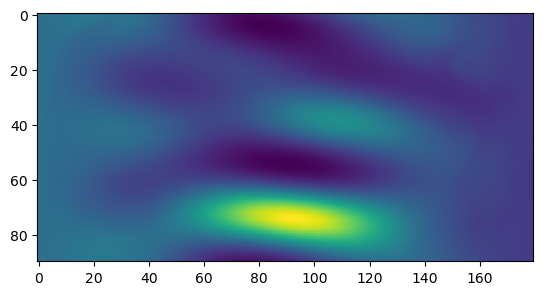

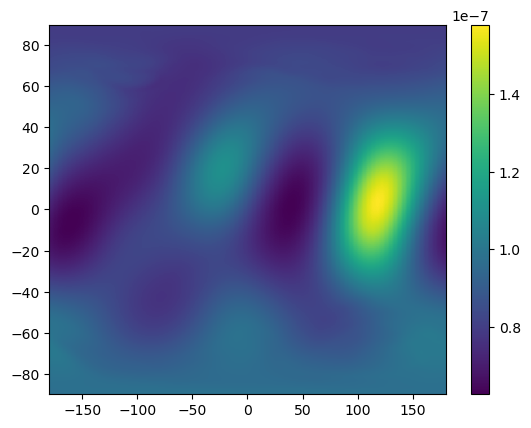

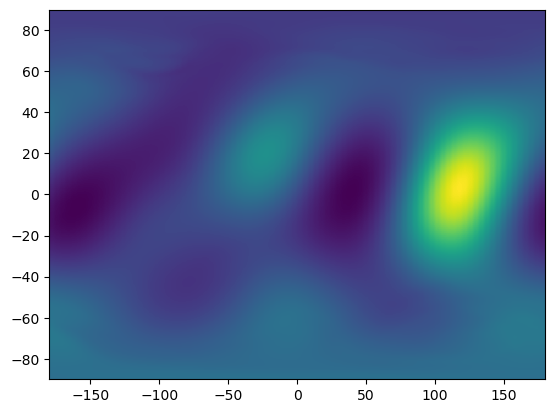

In [46]:
plt.imshow(a)
plt.show()
b = a.T
plt.imshow(np.flip(b, axis =0),  extent = [-180,180,-90,90], aspect = 'auto')
plt.colorbar()
plt.show()
plt.imshow(b,  extent = [-180,180,-90,90], aspect = 'auto', origin = 'lower');

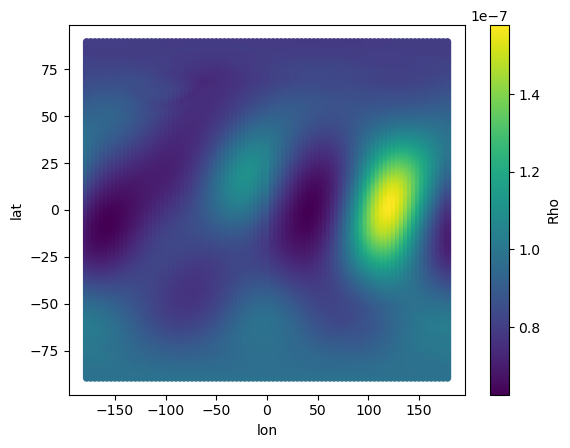

In [43]:
df_loc = df[df.alt == alts[5]]
df_loc.plot( x = 'lon', y = 'lat' , c = 'Rho', kind = 'scatter', colormap = 'viridis');

In [ ]:
a

In [248]:
def make_filter(params = None):
    # Define the cutoff frequencies
    lowcut = 1/(100/60)  # 100 minutes in units of sample^-1
    highcut = 1/(30/60) # 30 minutes in units of sample^-1

    # Define the Butterworth filter
    nyquist = 0.5 * 5 # 5 minutes is the sampling frequency
    low = lowcut / nyquist
    high = highcut / nyquist
    sos = signal.butter(2, [low, high], btype='bandstop', output='sos')
    return sos

def remove_background(time_series, sos):


    # Apply the filter to the time series
    filtered_data = signal.sosfiltfilt(sos, time_series)

    return filtered_data

In [9]:

def make_fits():
    """
    read in all data in df and then calculates bandpass filter for the data.
    
    inputs: none
    
    returns:
    fits: np array indexed at fits[ialt][ilat][ilon][col][time_array, len = len(times)]
    
    todo: you can thread this by splitting the alts into different threads.
    then just append the fits_full later.
    
    """
    sos = make_filter()
    fits_full = np.zeros((len(alts),len(lats), len(lons), len(gitm_cols), len(times)))
    pbar = tqdm(desc = 'making fits..', total = len(alts) * len(lats) * len(lons))
    for nalt, ialt in enumerate(alts):
        fits = np.array(len(times))
        
        df_sel = df[(df.alt == ialt)].reset_index(drop = True)
        for nlat, ilat in enumerate(lats):
            df_location = df_sel[(np.abs(df_sel.lat-ilat) < 0.2)].reset_index(drop = True)


            for nlon, ilon in enumerate(lons):
                df_location_sel = df_location[(np.abs(df_location.lon-ilon) < 0.2)].reset_index(drop = True)

                for ncol, icol in enumerate(gitm_cols):
                    bandpass_here = remove_background(df_location_sel[new_col], sos)

                    fits_full[nalt][-nlat][nlon][ncol] = bandpass_here
                pbar.update(1)

    return fits_full
            

In [ ]:
def make_fits(full_arr):
    

In [36]:
def read_in_gitm_file(f_idx):
    f = gitm_files[f_idx]
    gitm_df = pd.DataFrame()

    gitm_f = read_routines.read_gitm_file(f)
    gitm_df['alt'] = gitm_f[2].flatten()
    gitm_df['lat'] = np.rad2deg(gitm_f[1].flatten())
    gitm_df['lon'] = np.rad2deg(gitm_f[0].flatten())
    gitm_df['dtime'] = [gitm_dtimes[f_idx]] * len(gitm_df)

    for col in gitm_cols:
        col_idx = gitm_f['vars'].index(col)
        gitm_df[col] = gitm_f[col_idx].flatten()

    if gitm_alt_idxs != -1:
        list_of_dfs = []
        indiv_alts = np.sort(list(set(gitm_df.alt)))
        for alt_idx in gitm_alt_idxs:
            list_of_dfs.append(gitm_df.loc[np.where(gitm_df['alt'] == indiv_alts[alt_idx])])
        gitm_df = pd.concat(list_of_dfs, ignore_index = True).reset_index(drop = True)
    # shift lons b/c gitm gors from 0->360 but we need -180->180. Also get rid of ghost cells.
    gitm_df = gitm_df[(gitm_df.lon < 360) & (gitm_df.lon > 0)].reset_index(drop = True)
    new_lons = []
    for l in gitm_df.lon:
        if l > 180:
            new_lons.append(l - 360)
        else:
            new_lons.append(l)
    gitm_df.lon = new_lons
    gitm_df = gitm_df[(np.abs(gitm_df.lat) < 90)].reset_index(drop = True)
    return gitm_df

In [37]:
df = read_in_gitm_file(storm_start_index)

In [38]:
df

,alt,lat,lon,dtime,Rho,[O(!U3!NP)],[O!D2!N],[N!D2!N],[N(!U4!NS)],[NO],...,[NO!U+!N],[O!D2!U+!N],[N!D2!U+!N],[N!U+!N],[O(!U2!ND)!U+!N],[O(!U2!NP)!U+!N],[H!U+!N],[He!U+!N],[e-],eTemperature
0,109292.436412,-89.5,2.0,2011-05-21 13:40:00,9.838752e-08,2.897422e+17,3.154547e+17,1.574718e+18,1.603944e+12,6.749773e+12,...,2.184174e+10,2.687532e+10,9.683287e+06,8.910306e-01,6.204467e+04,3.088408e+04,1.0,3.151029e-15,4.873368e+10,205.742756
1,109292.436412,-88.5,2.0,2011-05-21 13:40:00,9.823762e-08,2.894091e+17,3.149560e+17,1.572277e+18,1.580345e+12,7.489109e+12,...,2.218499e+10,2.644630e+10,9.819542e+06,8.835034e-01,6.207862e+04,3.086074e+04,1.0,3.147082e-15,4.864810e+10,203.595858
2,109292.436412,-87.5,2.0,2011-05-21 13:40:00,9.783941e-08,2.904342e+17,3.132340e+17,1.565156e+18,1.576963e+12,8.244498e+12,...,2.327253e+10,2.735014e+10,1.076458e+07,9.769021e-01,6.839463e+04,3.390103e+04,1.0,3.145280e-15,5.064119e+10,205.586732
3,109292.436412,-86.5,2.0,2011-05-21 13:40:00,9.743950e-08,2.916737e+17,3.112361e+17,1.558191e+18,1.574041e+12,8.878190e+12,...,2.501227e+10,2.997723e+10,1.247613e+07,1.136927e+00,8.242738e+04,4.083032e+04,1.0,3.144584e-15,5.501113e+10,207.628955
4,109292.436412,-85.5,2.0,2011-05-21 13:40:00,9.709240e-08,2.926713e+17,3.093299e+17,1.552388e+18,1.574940e+12,9.385495e+12,...,2.855467e+10,3.693133e+10,1.739910e+07,1.587832e+00,1.190183e+05,5.891757e+04,1.0,3.144751e-15,6.551632e+10,209.738276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64795,513110.214043,85.5,-2.0,2011-05-21 13:40:00,1.104899e-12,3.657345e+13,4.475498e+10,2.207914e+12,7.357902e+11,1.670531e+09,...,7.527297e+07,2.802438e+07,9.207574e+07,8.577257e+09,1.436400e+09,2.535579e+07,1.0,1.945936e+07,3.771403e+11,2117.811079
64796,513110.214043,86.5,-2.0,2011-05-21 13:40:00,1.093791e-12,3.621513e+13,4.480151e+10,2.179024e+12,7.287361e+11,1.678633e+09,...,7.472156e+07,2.822695e+07,9.208388e+07,8.534167e+09,1.440264e+09,2.515793e+07,1.0,1.972024e+07,3.726883e+11,2122.655556
64797,513110.214043,87.5,-2.0,2011-05-21 13:40:00,1.082721e-12,3.585381e+13,4.485119e+10,2.154861e+12,7.175657e+11,1.683218e+09,...,7.433357e+07,2.830240e+07,9.153180e+07,8.468685e+09,1.435384e+09,2.493536e+07,1.0,1.990386e+07,3.706361e+11,2125.502112
64798,513110.214043,88.5,-2.0,2011-05-21 13:40:00,1.073090e-12,3.555066e+13,4.503203e+10,2.129888e+12,7.022268e+11,1.689053e+09,...,7.391930e+07,2.837667e+07,9.026164e+07,8.368197e+09,1.424271e+09,2.472927e+07,1.0,2.016991e+07,3.713965e+11,2130.851748


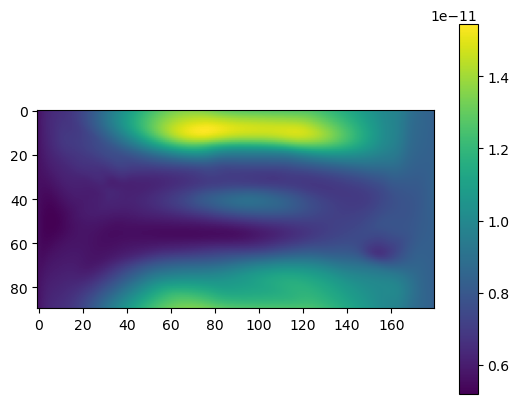

In [84]:
a = gitmbins[0,0,:,:,30]
plt.imshow(a)
plt.colorbar()

In [144]:
np.max(a)

6.387905062299247

In [ ]:
with Pool(num_pool_workers) as pool:
    df = pool.map(read_in_gitm_file, list(range(plot_start_idx, plot_end_idx)))
    
df = pd.concat(df, ignore_index = True).reset_index(drop = True)

if global_lat_lim:
    df = df[np.abs(df.lat) <= global_lat_lim].reset_index(drop = True)

lats, lons, alts  = np.unique(df.lat), np.unique(df.lon), np.unique(df.alt)

times = np.unique(df.dtime)

In [ ]:
import aacgmv2, time
import pandas as pd
import numpy as np
from multiprocessing import Pool
import math, os, shutil
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from scipy.io import readsav
import pymap3d as pm
import glob
import datetime, statistics
from aetherpy.io import read_routines
from math import cos, radians, sin, sqrt
from scipy import spatial, signal

from spacepy.coordinates import Coords
from spacepy.time import Ticktock
import fnmatch


from mpl_toolkits.basemap import Basemap
import geopandas

from scipy.interpolate import LinearNDInterpolator, interp1d

%matplotlib inline

## Settings

In [ ]:
dtime_storm_start = datetime.datetime(2011,5,21,13,40) 
plot_start_delta  = 4   #hours before storm onset to start making plots
plot_end_delta    = 10  # hours after storm onset to end plots. Set to -1 to run for the whole time


gitm_cols = ['Rho', '[O(!U3!NP)]', '[O!D2!N]', '[N!D2!N]', '[N(!U4!NS)]', '[NO]', '[He]', '[N(!U2!ND)]', '[N(!U2!NP)]', '[H]', '[CO!D2!N]', '[O(!U1!ND)]', 'Temperature', 'V!Dn!N(east)', 'V!Dn!N(north)', 'V!Dn!N(up)', 'V!Dn!N(up,O(!U3!NP))', 'V!Dn!N(up,O!D2!N)', 'V!Dn!N(up,N!D2!N)', 'V!Dn!N(up,N(!U4!NS))', 'V!Dn!N(up,NO)', 'V!Dn!N(up,He)', '[O_4SP_!U+!N]', '[NO!U+!N]', '[O!D2!U+!N]', '[N!D2!U+!N]', '[N!U+!N]', '[O(!U2!ND)!U+!N]', '[O(!U2!NP)!U+!N]', '[H!U+!N]', '[He!U+!N]', '[e-]', 'eTemperature', 'iTemperature', 'V!Di!N(east)', 'V!Di!N(north)', 'V!Di!N(up)'] # which gitm columns do you want plotted?


gitm_path = "/home/axb170054/scratch/GITM-testing/test_folders/step_function_driving/SAMI3-stretch/gitm_data/"


gitm_alt_idxs = [7,15,30,40] #set this to -1 if you want all columns
gitm_keo_lons = [-90,2,90,-178]

global_lat_lim = None # will limit all plots latitude. Must be none or less than keo_lat_lim

keo_lat_lim = 65 # limits keos to +/- degrees of lat. 

num_pool_workers = 10 # number of workers to use in multithreading jobs. Set to 1 if you don't know what this means.

both_map_plots = True # make both_map_plots filtered and raw maps? if you only want one put it as a str ('raw'/'filt')


available gitm cols are:
    ['Longitude', 'Latitude', 'Altitude', 'Rho', '[O(!U3!NP)]', '[O!D2!N]', '[N!D2!N]', '[N(!U4!NS)]', '[NO]', '[He]', '[N(!U2!ND)]', '[N(!U2!NP)]', '[H]', '[CO!D2!N]', '[O(!U1!ND)]', 'Temperature', 'V!Dn!N(east)', 'V!Dn!N(north)', 'V!Dn!N(up)', 'V!Dn!N(up,O(!U3!NP))', 'V!Dn!N(up,O!D2!N)', 'V!Dn!N(up,N!D2!N)', 'V!Dn!N(up,N(!U4!NS))', 'V!Dn!N(up,NO)', 'V!Dn!N(up,He)', '[O_4SP_!U+!N]', '[NO!U+!N]', '[O!D2!U+!N]', '[N!D2!U+!N]', '[N!U+!N]', '[O(!U2!ND)!U+!N]', '[O(!U2!NP)!U+!N]', '[H!U+!N]', '[He!U+!N]', '[e-]', 'eTemperature', 'iTemperature', 'V!Di!N(east)', 'V!Di!N(north)', 'V!Di!N(up)']

In [ ]:
gitm_keo_save_path = "/home/axb170054/scratch/made_plots/SimStormPaper/keos/"
gitm_map_save_path = "/home/axb170054/scratch/made_plots/SimStormPaper/maps/"

## Set up some useful functions:

In [ ]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
# for the maps!

In [ ]:
# This will be used in plotting:
gitm_colnames_friendly = {'Rho': 'Total Neutral Density', '[O(!U3!NP)]': 'O(3P)', '[O!D2!N]': 'O2', '[N!D2!N]': 'N2', '[N(!U4!NS)]': 'N(4S)', '[NO]': 'NO', '[He]': 'He', '[N(!U2!ND)]': 'N(2D)', '[N(!U2!NP)]': 'N(2P)', '[H]': 'H', '[CO!D2!N]': 'CO2', '[O(!U1!ND)]': 'O(1D)', 'Temperature': 'Temperature', 'V!Dn!N(east)': 'Vn(east)', 'V!Dn!N(north)': 'Vn(north)', 'V!Dn!N(up)': 'Vn(up)', 'V!Dn!N(up,O(!U3!NP))': 'Vn(up,O(3P))', 'V!Dn!N(up,O!D2!N)': 'Vn(up,O2)', 'V!Dn!N(up,N!D2!N)': 'Vn(up,N2)', 'V!Dn!N(up,N(!U4!NS))': 'Vn(up,N(4S))', 'V!Dn!N(up,NO)': 'Vn(up,NO)', 'V!Dn!N(up,He)': 'Vn(up,He)', '[O_4SP_!U+!N]':'O(4Sp)+', '[NO!U+!N]': 'NO+', '[O!D2!U+!N]': 'O2+', '[N!D2!U+!N]': 'N2+', '[N!U+!N]': 'N+', '[O(!U2!ND)!U+!N]': 'O(2D)+', '[O(!U2!NP)!U+!N]': 'O(2P)+', '[H!U+!N]': 'H+', '[He!U+!N]': 'He+', '[e-]': 'e-', 'eTemperature': 'eTemperature', 'iTemperature': 'iTemperature', 'V!Di!N(east)': 'Vi(east)', 'V!Di!N(north)': 'Vi(north)', 'V!Di!N(up)': 'Vi(up)'}

In [ ]:
def read_in_gitm_file(f_idx):
    f = gitm_files[f_idx]
    gitm_df = pd.DataFrame()

    gitm_f = read_routines.read_gitm_file(f)
    gitm_df['alt'] = gitm_f[2].flatten()
    gitm_df['lat'] = np.rad2deg(gitm_f[1].flatten())
    gitm_df['lon'] = np.rad2deg(gitm_f[0].flatten())
    gitm_df['dtime'] = [gitm_dtimes[f_idx]] * len(gitm_df)

    for col in gitm_cols:
        col_idx = gitm_f['vars'].index(col)
        gitm_df[col] = gitm_f[col_idx].flatten()

    if gitm_alt_idxs != -1:
        list_of_dfs = []
        indiv_alts = np.sort(list(set(gitm_df.alt)))
        for alt_idx in gitm_alt_idxs:
            list_of_dfs.append(gitm_df.loc[np.where(gitm_df['alt'] == indiv_alts[alt_idx])])
        gitm_df = pd.concat(list_of_dfs, ignore_index = True).reset_index(drop = True)
    # shift lons b/c gitm gors from 0->360 but we need -180->180. Also get rid of ghost cells.
    gitm_df = gitm_df[(gitm_df.lon < 360) & (gitm_df.lon > 0)].reset_index(drop = True)
    new_lons = []
    for l in gitm_df.lon:
        if l > 180:
            new_lons.append(l - 360)
        else:
            new_lons.append(l)
    gitm_df.lon = new_lons
    gitm_df = gitm_df[(np.abs(gitm_df.lat) < 90)].reset_index(drop = True)
    return gitm_df

In [ ]:
def bandpass_filter(noisy_signal):
    sampling_frequency = 1/(5*60)  # Sampling frequency (in Hz) #5 mins
    low_cutoff_frequency = 1/(90*60)  # Low cutoff frequency (in Hz) #90 mins
    high_cutoff_frequency = 1/(50*60)  # High cutoff frequency (in Hz) #50 mins

    coefficients = signal.butter(4, [low_cutoff_frequency, high_cutoff_frequency], btype='bandpass', fs=sampling_frequency)
    bps = np.array(signal.filtfilt(coefficients[0], coefficients[1], noisy_signal))
    return bps

In [ ]:
def make_filter(params = None):
    # Define the cutoff frequencies
    lowcut = 1/(100/60)  # 100 minutes in units of sample^-1
    highcut = 1/(30/60) # 30 minutes in units of sample^-1

    # Define the Butterworth filter
    nyquist = 0.5 * 5 # 5 minutes is the sampling frequency
    low = lowcut / nyquist
    high = highcut / nyquist
    sos = signal.butter(2, [low, high], btype='bandstop', output='sos')
    return sos

def remove_background(time_series, sos):


    # Apply the filter to the time series
    filtered_data = signal.sosfiltfilt(sos, time_series)

    return filtered_data

In [ ]:

def make_fits():
    """
    read in all data in df and then calculates bandpass filter for the data.
    
    inputs: none
    
    returns:
    fits: np array indexed at fits[ialt][ilat][ilon][col][time_array, len = len(times)]
    
    todo: you can thread this by splitting the alts into different threads.
    then just append the fits_full later.
    
    """
    sos = make_filter()
    fits_full = np.zeros((len(alts),len(lats), len(lons), len(gitm_cols), len(times)))
    pbar = tqdm(desc = 'making fits..', total = len(alts) * len(lats) * len(lons))
    for nalt, ialt in enumerate(alts):
        fits = np.array(len(times))
        
        df_sel = df[(df.alt == ialt)].reset_index(drop = True)
        for nlat, ilat in enumerate(lats):
            df_location = df_sel[(np.abs(df_sel.lat-ilat) < 0.2)].reset_index(drop = True)


            for nlon, ilon in enumerate(lons):
                df_location_sel = df_location[(np.abs(df_location.lon-ilon) < 0.2)].reset_index(drop = True)

                for ncol, icol in enumerate(gitm_cols):
                    bandpass_here = remove_background(df_location_sel[new_col], sos)

                    fits_full[nalt][-nlat][nlon][ncol] = bandpass_here
                pbar.update(1)

    return fits_full
            

In [ ]:
def UT_from_Storm_onset(itime):
    """input the index of timelist
    
    returns the UT as HH:MM from storm onset, as a string"""
    l = (pd.Timestamp(itime) - dtime_storm_start)/ pd.Timedelta('1 minute') # get pd datetime of this iter, find minute diff from storm start
    if l > 0:
        hrs = np.floor(l/60)
        hrs = str(int(hrs)).rjust(2,'0')
    else:
        hrs = np.ceil(l/60)
        hrs = str(int(hrs)).rjust(2,'0')
    mins = str(int(np.abs(l)%60)).rjust(2,'0')
    ut = hrs + ':' + mins
    return ut

## Do GITM Plots First

In [ ]:
gitm_files = np.sort(glob.glob(gitm_path+'3DALL*'))

gitm_dtimes = []
for i in gitm_files:
    yy, MM, dd, hr, mm, sec = i[-17:-15], i[-15:-13], i[-13:-11], i[-10:-8], i[-8:-6], i[-6:-4]
    gitm_dtimes.append(datetime.datetime(int('20' + yy), int(MM), int(dd), int(hr), int(mm), int(sec)))
    
storm_start_index = np.argmin(np.abs(np.array(gitm_dtimes)-dtime_storm_start))
plot_start_idx = np.argmin(np.abs(np.array(gitm_dtimes)-(dtime_storm_start - datetime.timedelta(hours = plot_start_delta))))
plot_end_idx = np.argmin(np.abs(np.array(gitm_dtimes)-(dtime_storm_start + datetime.timedelta(hours = plot_end_delta)))) if plot_end_delta != -1 else -1

### Read in all gitm files

In [ ]:
with Pool(num_pool_workers) as pool:
    df = pool.map(read_in_gitm_file, list(range(plot_start_idx, plot_end_idx)))
    
df = pd.concat(df, ignore_index = True).reset_index(drop = True)

if global_lat_lim:
    df = df[np.abs(df.lat) <= global_lat_lim].reset_index(drop = True)

lats, lons, alts  = np.unique(df.lat), np.unique(df.lon), np.unique(df.alt)

times = np.unique(df.dtime)

In [1]:
lst = list(range(0,360,6))

In [3]:
lst[::4]

[0, 24, 48, 72, 96, 120, 144, 168, 192, 216, 240, 264, 288, 312, 336]

In [4]:
lst[0:6]

[0, 6, 12, 18, 24, 30]

In [11]:
s = read_routines.read_gitm_headers(['/petastore/phil/GITM/gitm_model_runs/gitm2/run/data/grace1_001_t050822_000000.bin'])

In [12]:
s

{'nfiles': 1,
 'version': 21.14,
 'nlons': 1,
 'nlats': 1,
 'nalts': 54,
 'vars': ['Longitude',
  'Latitude',
  'Altitude',
  'Rho',
  '[O(!U3!NP)]',
  '[O!D2!N]',
  '[N!D2!N]',
  '[N(!U4!NS)]',
  '[NO]',
  '[He]',
  '[N(!U2!ND)]',
  '[N(!U2!NP)]',
  '[H]',
  '[CO!D2!N]',
  '[O(!U1!ND)]',
  'Temperature',
  'V!Dn!N(east)',
  'V!Dn!N(north)',
  'V!Dn!N(up)',
  'V!Dn!N(up,O(!U3!NP))',
  'V!Dn!N(up,O!D2!N)',
  'V!Dn!N(up,N!D2!N)',
  'V!Dn!N(up,N(!U4!NS))',
  'V!Dn!N(up,NO)',
  'V!Dn!N(up,He)',
  '[O_4SP_!U+!N]',
  '[NO!U+!N]',
  '[O!D2!U+!N]',
  '[N!D2!U+!N]',
  '[N!U+!N]',
  '[O(!U2!ND)!U+!N]',
  '[O(!U2!NP)!U+!N]',
  '[H!U+!N]',
  '[He!U+!N]',
  '[e-]',
  'eTemperature',
  'iTemperature',
  'V!Di!N(east)',
  'V!Di!N(north)',
  'V!Di!N(up)'],
 'time': [datetime.datetime(2005, 8, 22, 0, 1, 1, 477000)],
 'filename': ['/petastore/phil/GITM/gitm_model_runs/gitm2/run/data/grace1_001_t050822_000000.bin']}

In [13]:
import datetime as dt
from netCDF4 import Dataset
import numpy as np
import os
from struct import unpack
import re

from aetherpy.utils.time_conversion import epoch_to_datetime
from aetherpy import logger

In [90]:
def read_gitm_file(filename, file_vars=None):
    """Read list of variables from one GITM file.
    Parameters
    ----------
    filename : str
        GITM file to read
    file_vars : list or NoneType
        List of desired variable names to read or None to read all
        (default=None)
    Returns
    -------
    data : dict
        Dict with keys 'time', which contains a datetime object specifying the
        time of the file and zero-offset indices, corresponding to the
        variable names in `file_vars` that holds arrays of the specified data.
        Also contains version number, dimensions, and a list of the variable
        names.
    """
    data_full = []
    # data = {"vars": []}
    
    logger.info("Reading file : ", filename)

    if not os.path.isfile(filename):
        raise IOError('input file does not exist')

    with open(filename, 'rb', ) as fin:
        
        for loop_num in range(3):
            
            # Determine the correct endian
            end_char = '>'
            raw_rec_len = fin.read(4)
            rec_len = (unpack(end_char + 'l', raw_rec_len))[0]
            if rec_len > 10000 or rec_len < 0:
                # Ridiculous record length implies wrong endian.
                end_char = '<'
                rec_len = (unpack(end_char + 'l', raw_rec_len))[0]

            # Read version; read fortran footer+data.
            data["version"] = unpack(end_char + 'd', fin.read(rec_len))[0]


            _, rec_len = unpack(end_char + '2l', fin.read(8))

            # Read grid size information.
            data["nlons"], data["nlats"], data["nalts"] = unpack(
                end_char + 'lll', fin.read(rec_len))
            _, rec_len = unpack(end_char + '2l', fin.read(8))

            # Read number of variables.
            num_vars = unpack(end_char + 'l', fin.read(rec_len))[0]
            _, rec_len = unpack(end_char + '2l', fin.read(8))

            if file_vars is None:
                file_vars = np.arange(0, num_vars, 1)

            # Collect variable names in a list
            for ivar in range(num_vars):
                vcode = iter_unpack(end_char + '%is' % (rec_len),
                               fin.read(rec_len))[0]
                var = vcode.decode('utf-8').replace(" ", "")
                data['vars'].append(var)
                dummy, rec_lec = unpack(end_char + '2l', fin.read(8))

            # Extract time
            rec_time = np.array(unpack(end_char + 'lllllll', fin.read(28)))
            rec_time[-1] *= 1000  # convert from millisec to microsec
            data["time"] = dt.datetime(*rec_time)

            # Header is this length:
            # Version + start/stop byte
            # nlons, nlats, nalts + start/stop byte
            # num_vars + start/stop byte
            # variable names + start/stop byte
            # time + start/stop byte

            iheader_length = 84 + num_vars * 48

            ntotal = data["nlons"] * data["nlats"] * data["nalts"]
            idata_length = ntotal * 8 + 8

            # Save the data for the desired variables
            for ivar in file_vars:
                fin.seek(iheader_length + ivar * idata_length)
                sdata = unpack(end_char + 'l', fin.read(4))[0]
                data[ivar] = np.array(
                    unpack(end_char + '%id' % (ntotal), fin.read(sdata))).reshape(
                        (data["nlons"], data["nlats"], data["nalts"]), order="F")

            data_full.append(data)

    return data_full

In [91]:
fname = '/petastore/phil/GITM/gitm_model_runs/gitm2/run/UA/data/grace1_001_t050822_000000.bin'
s = read_gitm_file(fname)

error: unpack requires a buffer of 4 bytes

In [75]:
len(s)

1

In [82]:
134217728/10074

13323.181258685725

In [83]:
13323*8

106584

In [36]:
with open(fname, 'rb') as fin:
    
    data_full = []
    
    for i in range(0,5):
        data = {"vars": []}
        # Determine the correct endian
        end_char = '>'
        raw_rec_len = fin.read(4)
        rec_len = (unpack(end_char + 'l', raw_rec_len))[0]
        if rec_len > 10000 or rec_len < 0:
            # Ridiculous record length implies wrong endian.
            end_char = '<'
            rec_len = (unpack(end_char + 'l', raw_rec_len))[0]

        # Read version; read fortran footer+data.
        data["version"] = unpack(end_char + 'd', fin.read(rec_len))[0]

        _, rec_len = unpack(end_char + '2l', fin.read(8))

        # Read grid size information.
        data["nlons"], data["nlats"], data["nalts"] = unpack(
            end_char + 'lll', fin.read(rec_len))
        _, rec_len = unpack(end_char + '2l', fin.read(8))

        # Read number of variables.
        num_vars = unpack(end_char + 'l', fin.read(rec_len))[0]
        _, rec_len = unpack(end_char + '2l', fin.read(8))

        file_vars = np.arange(0, num_vars, 1)

        # Collect variable names in a list
        for ivar in range(num_vars):
            vcode = unpack(end_char + '%is' % (rec_len),
                           fin.read(rec_len))[0]
            var = vcode.decode('utf-8').replace(" ", "")
            data['vars'].append(var)
            dummy, rec_lec = unpack(end_char + '2l', fin.read(8))

        # Extract time
        rec_time = np.array(unpack(end_char + 'lllllll', fin.read(28)))
        rec_time[-1] *= 1000  # convert from millisec to microsec
        data["time"] = dt.datetime(*rec_time)

        # Header is this length:
        # Version + start/stop byte
        # nlons, nlats, nalts + start/stop byte
        # num_vars + start/stop byte
        # variable names + start/stop byte
        # time + start/stop byte

        iheader_length = 84 + num_vars * 48

        ntotal = data["nlons"] * data["nlats"] * data["nalts"]
        idata_length = ntotal * 8 + 8

        # Save the data for the desired variables
        for ivar in file_vars:
            fin.seek(iheader_length + ivar * idata_length)
            sdata = unpack(end_char + 'l', fin.read(4))[0]
            data[ivar] = np.array(
                unpack(end_char + '%id' % (ntotal), fin.read(sdata))).reshape(
                    (data["nlons"], data["nlats"], data["nalts"]), order="F")

        data_full.append(data)

error: unpack requires a buffer of 8 bytes

In [33]:
fin.read(rec_len)

ValueError: read of closed file